### This script is a port of EnergyID's code that calculates a linear regression on heating data

# Imports and setup

General imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

OpenGrid-specific imports

In [2]:
from opengrid.library import houseprint
from opengrid import config
from opengrid.library import linearregression

c = config.Config()

Plotting settings

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

# Load Data

We are going to use gas consumption data and weather data. Because we don't want to overload the weather API, we will only use 1 location (Ukkel) and the caching library.

First, let's define the start and end date of our experiment. Let's take 1 year worth of data, starting with last month.

In [4]:
# If we want to get consumption for 12 months, we will need 13 months of data
end = pd.Timestamp.today().replace(day=1).normalize()
start = (end.replace(year=end.year-1) - pd.Timedelta(days=1))

#start = start.tz_localize('Europe/Brussels')
#end = end.tz_localize('Europe/Brussels')
print(start, end)

2015-03-31 00:00:00 2016-04-01 00:00:00


## Gas Data

Let's do something Python-esque and use a generator to fetch the data.

In [5]:
# Load the Houseprint, and sync all data
#hp = houseprint.Houseprint()
hp = houseprint.load_houseprint_from_file('cache_hp.hp')
hp.init_tmpo()
#hp.sync_tmpos()

Using tmpo database from /Users/Jan/.tmpo/tmpo.sqlite3


In [6]:
hp.save('cache_hp.hp')

Saved houseprint to /Users/Jan/opengrid/notebooks/cache_hp.hp


In [7]:
def gas_data_generator():
    for gas_sensor in hp.get_sensors(sensortype='gas'):
        df = gas_sensor.get_data(head=start, tail=end, unit='kWh', diff=False)
        df = df.tz_convert('Europe/Brussels')
        df = df.resample('MS')
        df = df.diff().dropna()
        df = df[df>0]
        if df.empty:
            continue
        yield df

Let's have a peek

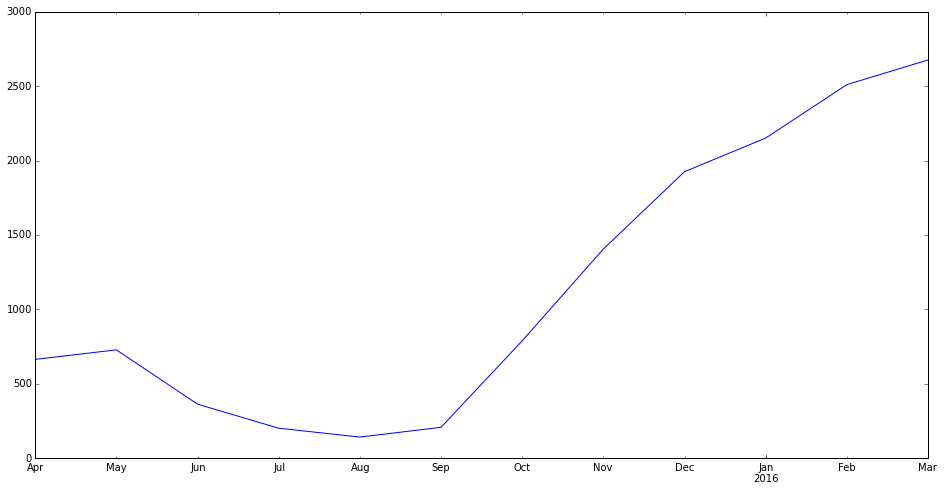

In [8]:
gas_data = gas_data_generator()
peek = next(gas_data)
#print(peek)
peek.plot()

## Weather Data

Run this block to download the weather data and save it to a pickle. This is a large request, and you can only do 2 or 3 of these per day before your credit with Forecast.io runs out!

TODO: Use the caching library for this.

To get the data run the cell below

```
from opengrid.library import forecastwrapper
api_key = c.get('Forecast.io', 'apikey')
weather = forecastwrapper.Weather(api_key=api_key, location='Ukkel, Belgium', start=start, end=end)
df = weather.days()
df.to_pickle('weather_ukkel_days.pkl')
```

In [10]:
weather_data = pd.read_pickle('weather_ukkel_days.pkl')
weather_data = weather_data.resample('MS', how='sum')
weather_data = weather_data.truncate(before=start, after=end-pd.Timedelta(days=1))

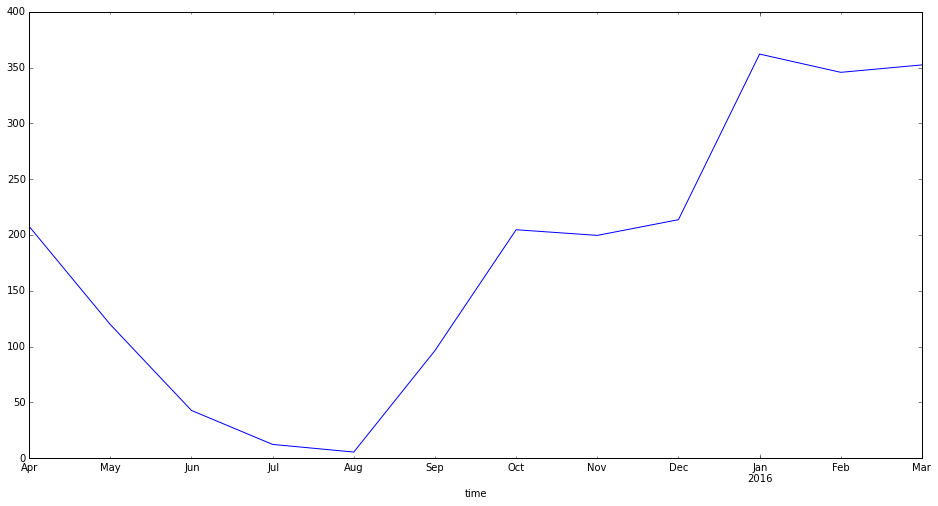

In [11]:
weather_data['heatingDegreeDays16.5'].plot()

# Put data together

We have defined an OpenGrid analysis as a class that takes a single DataFrame as input, so we'll create that dataframe.

I wrote a generator that uses our previously defined generator so you can generate while you generate.

In [12]:
def analysis_data_generator():
    gas_data = gas_data_generator()
    for gas_df in gas_data:
        df = pd.concat([gas_df, weather_data['heatingDegreeDays16.5']], axis=1).dropna()
        yield df

Let's have another peek

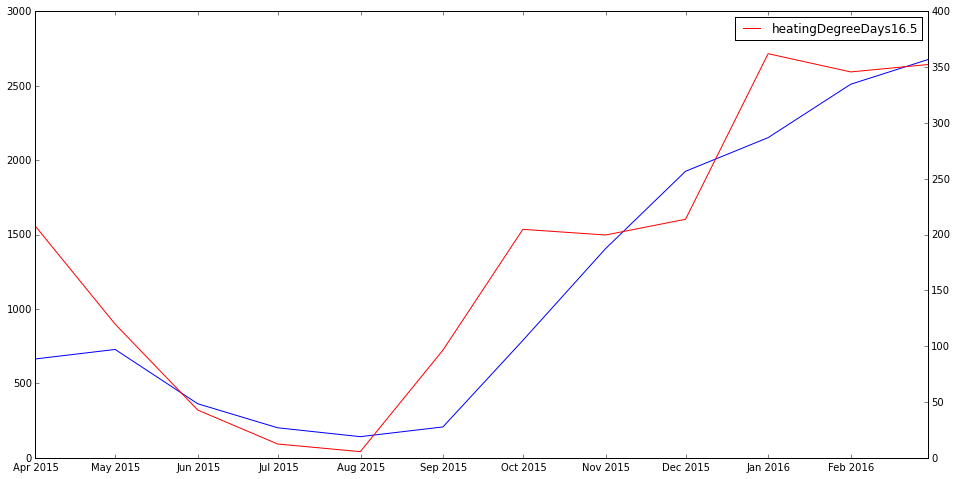

In [13]:
analysis_data = analysis_data_generator()
peek = next(analysis_data)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
for axis, column, color in zip([ax1, ax2], peek.columns, ['b', 'r']):
    axis.plot_date(peek.index, peek[column], '-', color=color, label=column)
plt.legend()

# Run Regression Analysis

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


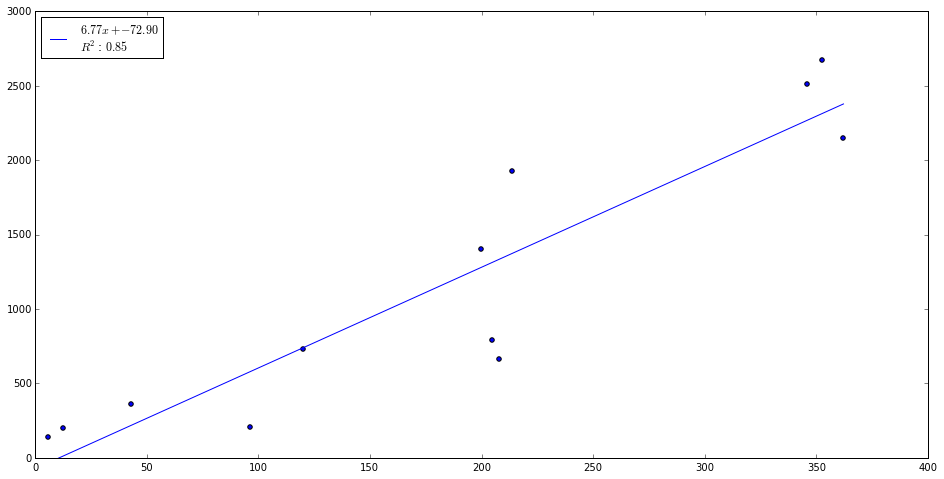

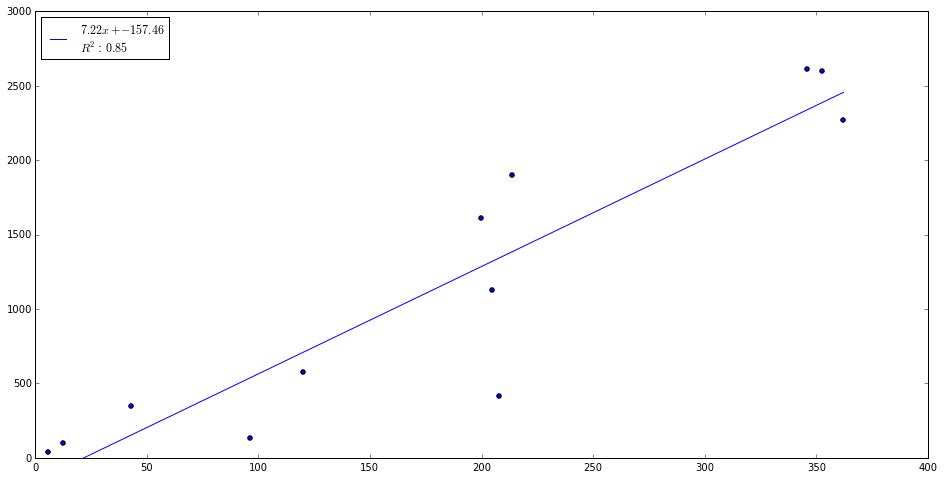

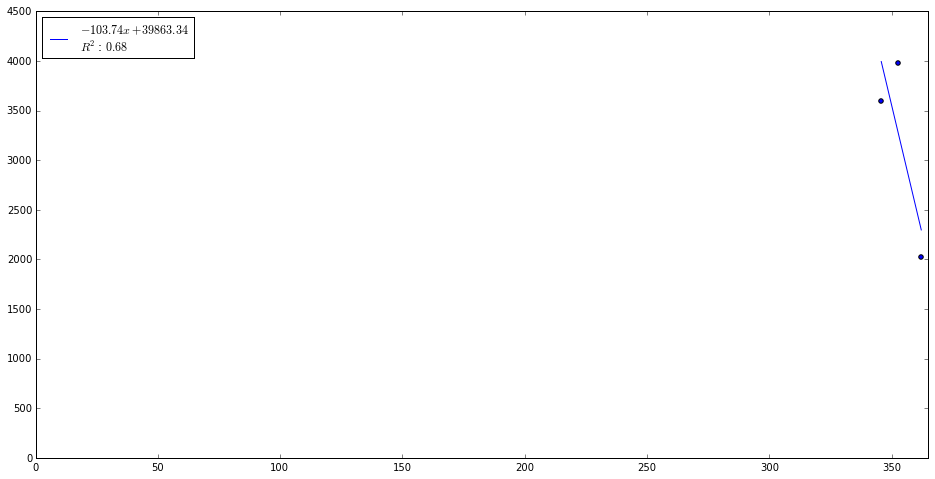

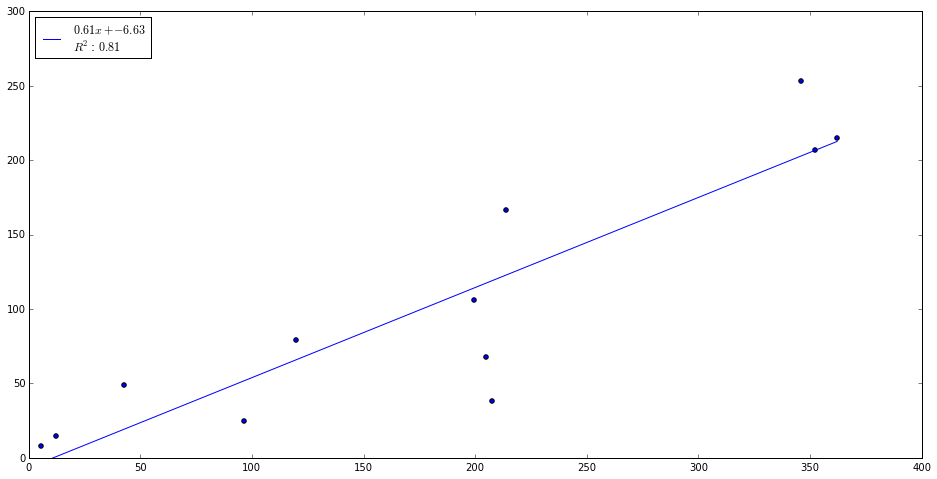

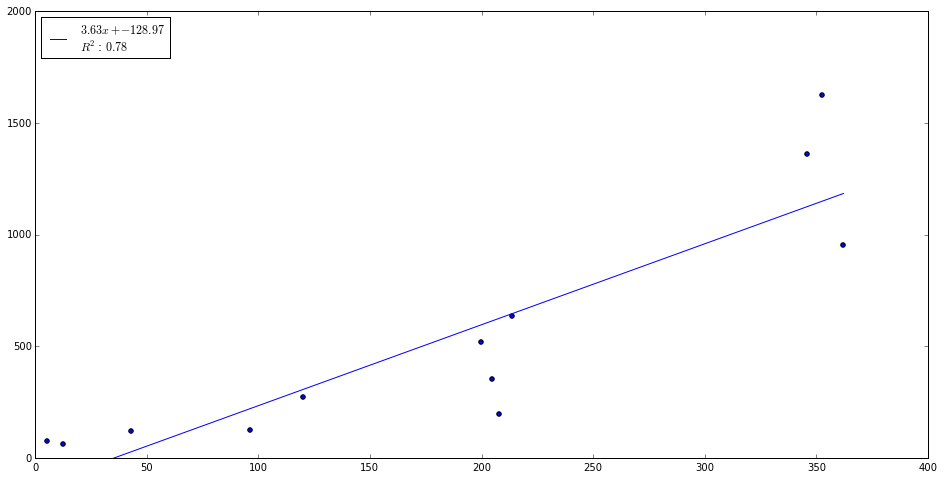

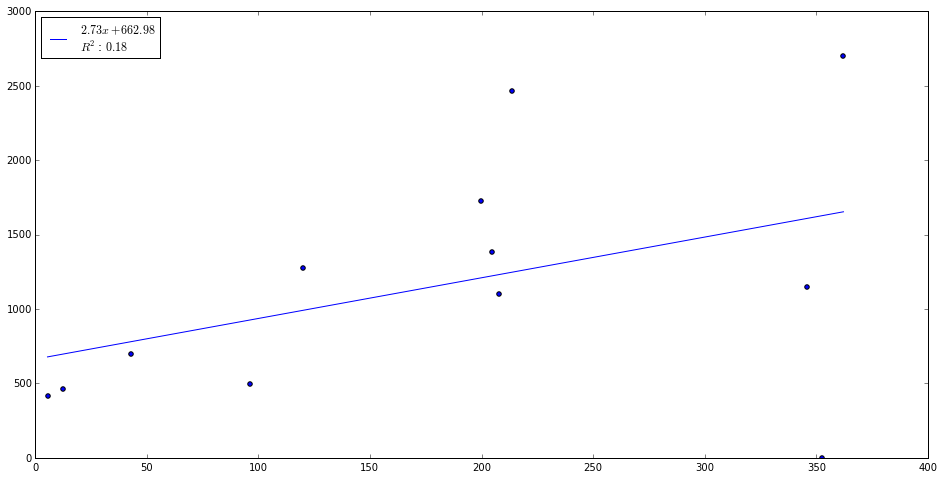

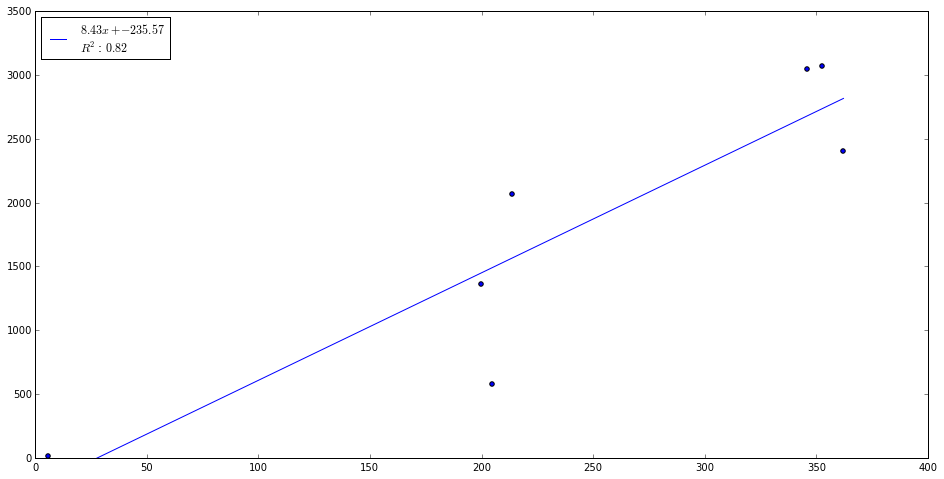

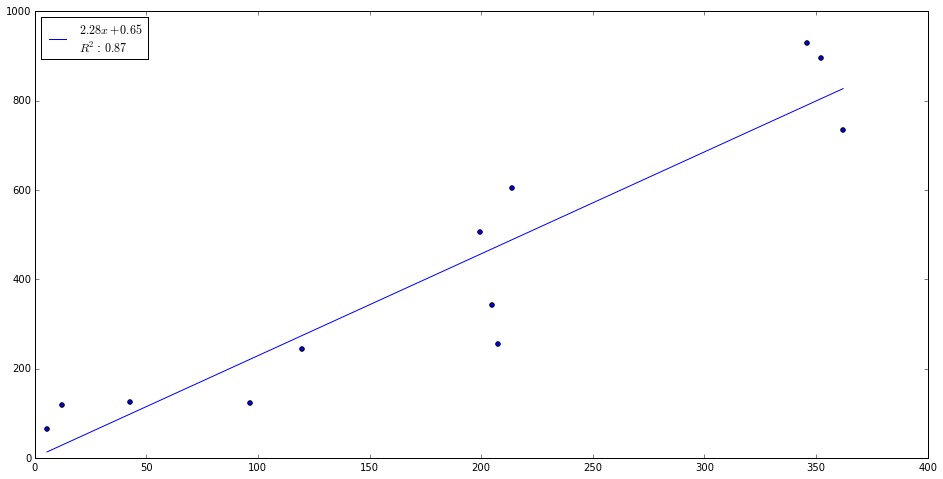

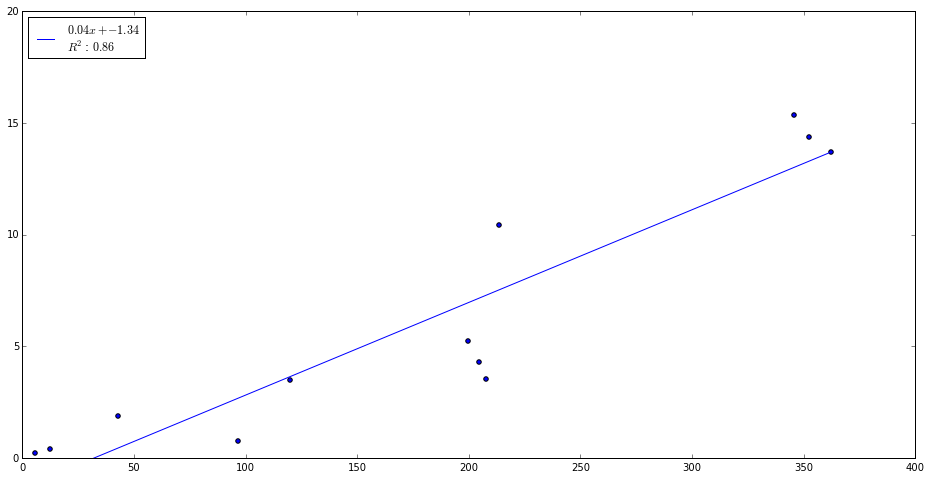

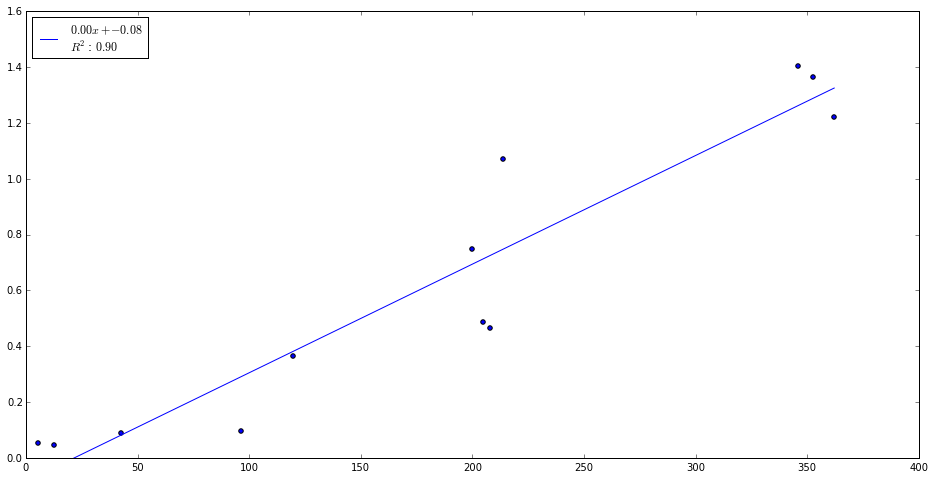

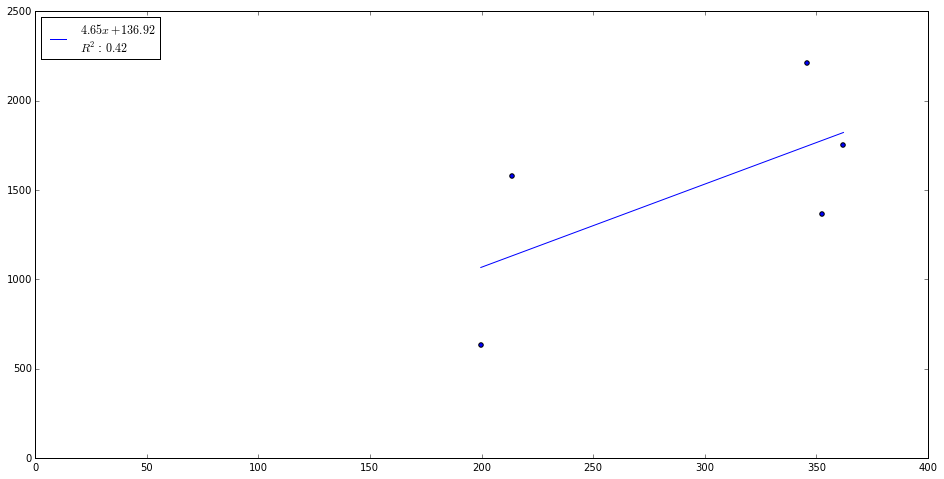

In [14]:
analysis_data = analysis_data_generator()
for data in analysis_data:
    
    # we need the names of the columns to pass to the analysis
    gas_column, degree_day_column = data.columns
    
    try:
        analysis = linearregression.LinearRegression(df=data,
                                                     independent_var=degree_day_column,
                                                     dependent_var=gas_column)
    except ValueError:
        continue
    fig = analysis.plot()
    fig.show()

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


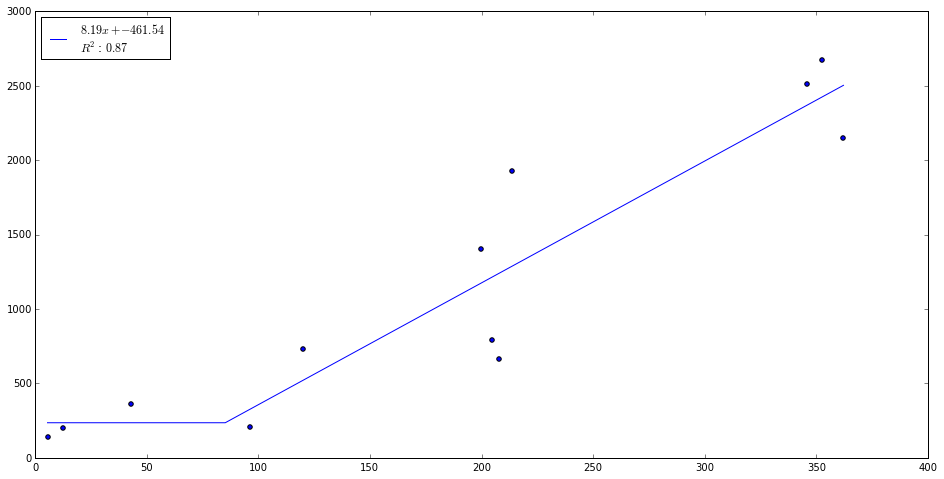

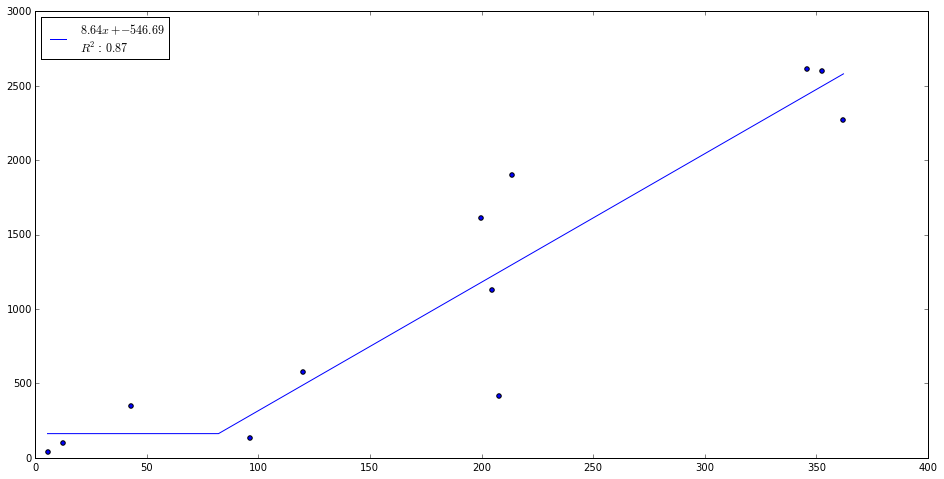

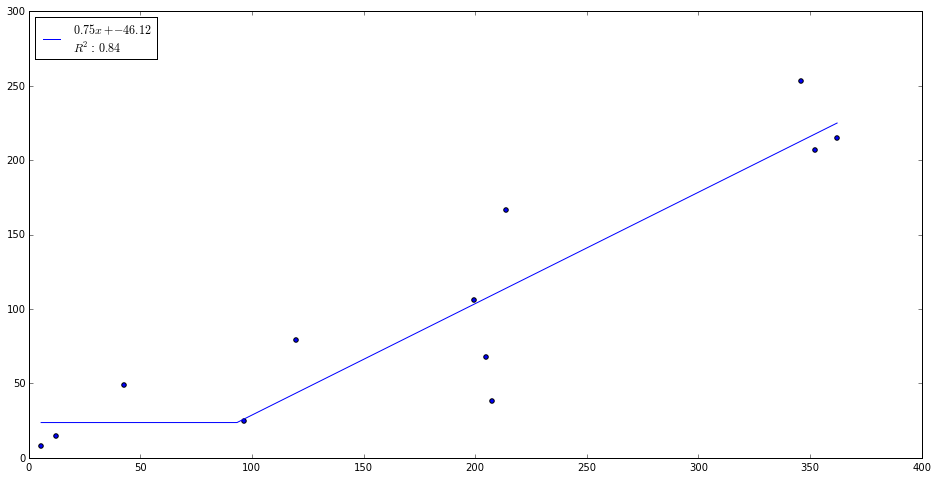

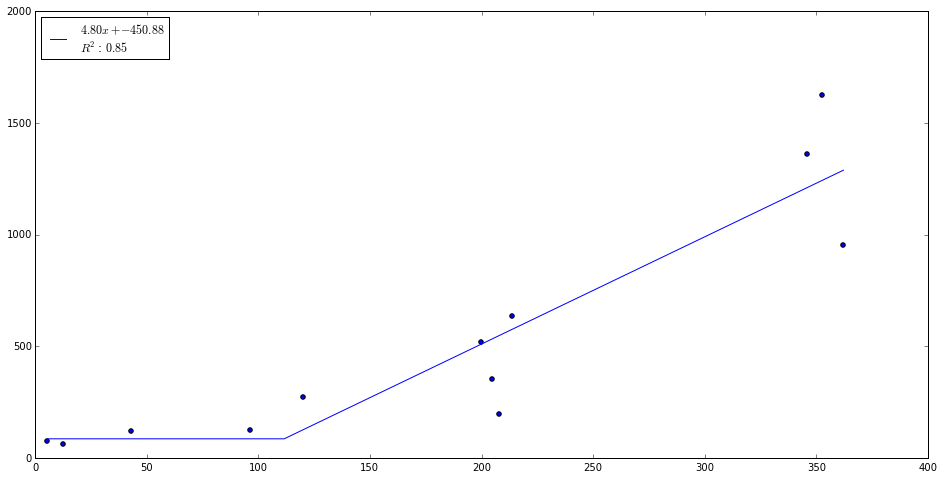

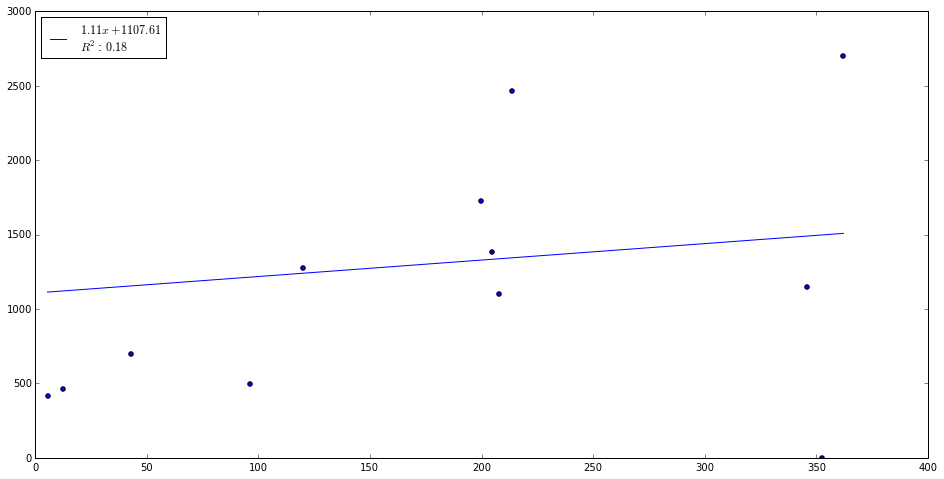

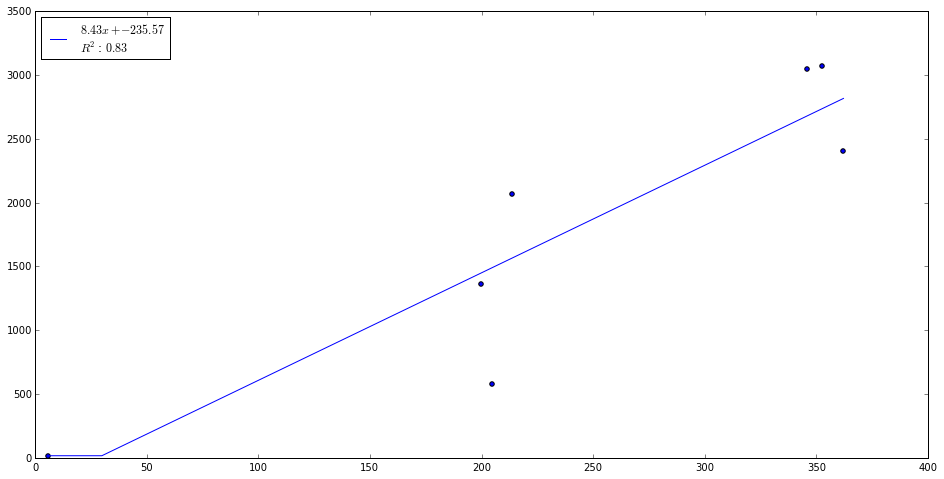

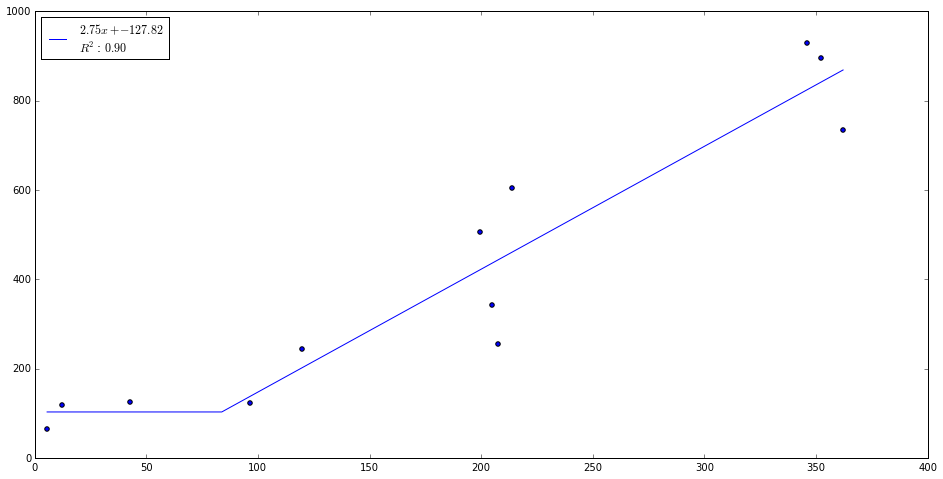

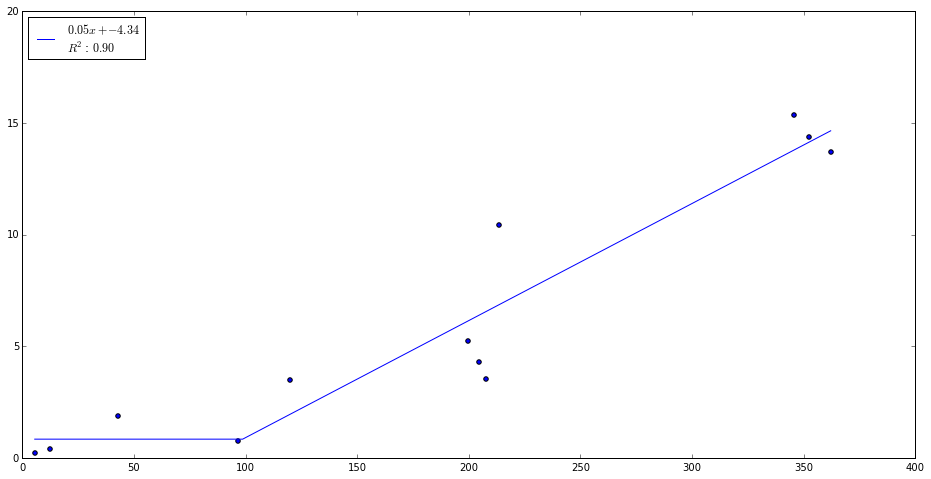

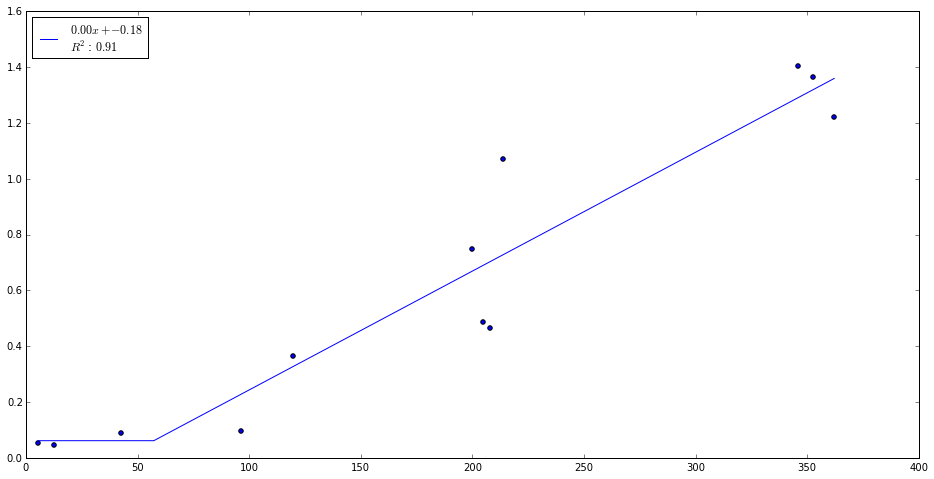

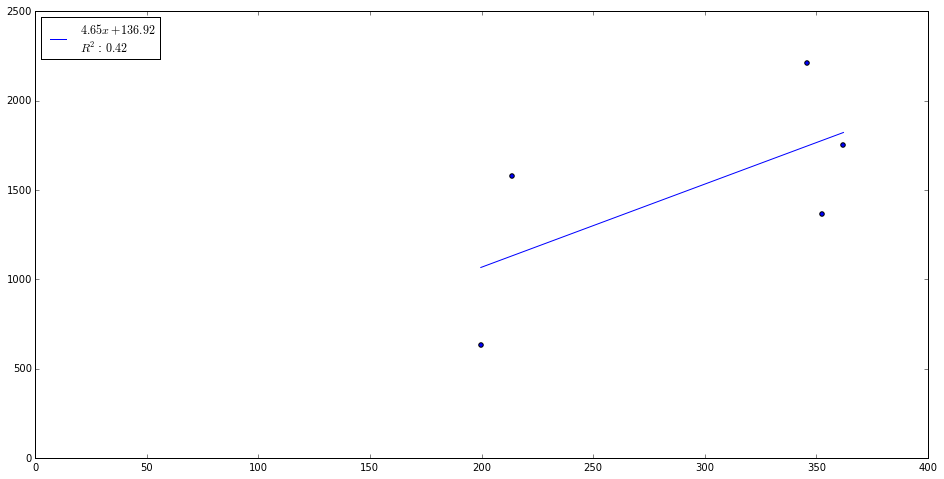

In [15]:
analysis_data = analysis_data_generator()
for data in analysis_data:
    
    # we need the names of the columns to pass to the analysis
    gas_column, degree_day_column = data.columns
    
    try:
        analysis = linearregression.LinearRegression3(df=data,
                                                      breakpoint=60,
                                                      percentage=0.5,
                                                      independent_var=degree_day_column,
                                                      dependent_var=gas_column)
    except ValueError:
        continue
    fig = analysis.plot()
    fig.show()